<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/11_Feature_learning/11_5_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 11: Principles of Feature Learning

# 11.5 Efficient Cross-Validation via Boosting

In this Section we introduce boosting, the first of two fundamental
paradigms for effective cross-validation described in this Chapter. In contrast to the naive form of cross-validation described in the previous Section, with *boosting based cross validation* we perform our model search by taking a *single* high capacity model and optimize it *one unit at-a-time*, resulting in a much more efficient high resolution cross-validation procedure.  While in principle any universal approximator can be used with boosting, this approach is often used as the cross-validation method of choice when employing tree-based universal approximators (as discussed further in Section 14.2).

In [ ]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_11_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/11_Feature_learning/chapter_11_datasets
    else:
        print('chapter_11_datasets already cloned!')

    # clone library subdirectory
    if not Path('chapter_11_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/11_Feature_learning/chapter_11_library
    else:
        print('chapter_11_library already cloned!')

    # clone images
    if not Path('chapter_11_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/11_Feature_learning/chapter_11_images
    else:
        print('chapter_11_images already cloned!')

    # clone videos
    if not Path('chapter_11_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/11_Feature_learning/chapter_11_videos
    else:
        print('chapter_11_videos already cloned!')


# append path for local library, data, and image import
import sys, copy
sys.path.append('./chapter_11_library') 

# backend file
import boosting_regression_animators
from intro_boost_library import stump_booster, net_booster

# data path
data_path_1 = 'chapter_11_datasets/noisy_sin_sample.csv'

# image paths
image_path_1 = "chapter_11_images/Figure_11_32.png"
image_path_2 = "chapter_11_images/Figure_11_33.png"

# video paths
video_path_1 = 'chapter_11_videos/animation_7.mp4'
video_path_2 = 'chapter_11_videos/animation_8.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
import autograd.numpy as np
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## The big picture

The basic principle behind boosting based cross-validation is to progressively build a high capacity model *one unit at-a-time*, using units from a single type of universal approximator (e.g., one of those simple exemplars outlined in Section 11.2.3, as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_M\left(\mathbf{x}\right)w_M.
\label{equation:boosting-original-construct}
\end{equation}

We do this sequentially in $M$ 'rounds' of boosting where at each round we add one unit to the model, completely optimizing this unit's parameters alone along with its corresponding linear combination weight (we keep these parameters fixed at these optimally tuned values forever more).  Alternatively we can think of this procedure as beginning with a high capacity model of the form above and - in $M$ rounds - optimizing the parameters of each unit one unit at-a-time (a form of coordinate-wise optimization).  In either case, performing boosting in this way produces a sequence of $M$ tuned models that generally increase in complexity with respect to the training dataset, which we denote compactly as $\left\{\text{model}_m\right\}_{m=1}^M$, where the $m^{th}$ model consists of $m$ tuned units (each having been tuned one at-a-time in the preceding rounds).   Since just one unit is optimized at-a-time, boosting tends to provide a computationally efficient high resolution form of model search.

The general boosting procedure tends to produce training/validation error curves that generally look like those shown in the top panel of [Figure 11.32](#figure-11-32).  As with the naive approach detailed in the previous Section, here too we tend to see training error decrease as $m$ grows larger while validation error tends to start high where underfitting occurs, dip down to a minimum value (perhaps oscillating more than the one time illustrated here), and rise back up when overfitting begins.

---

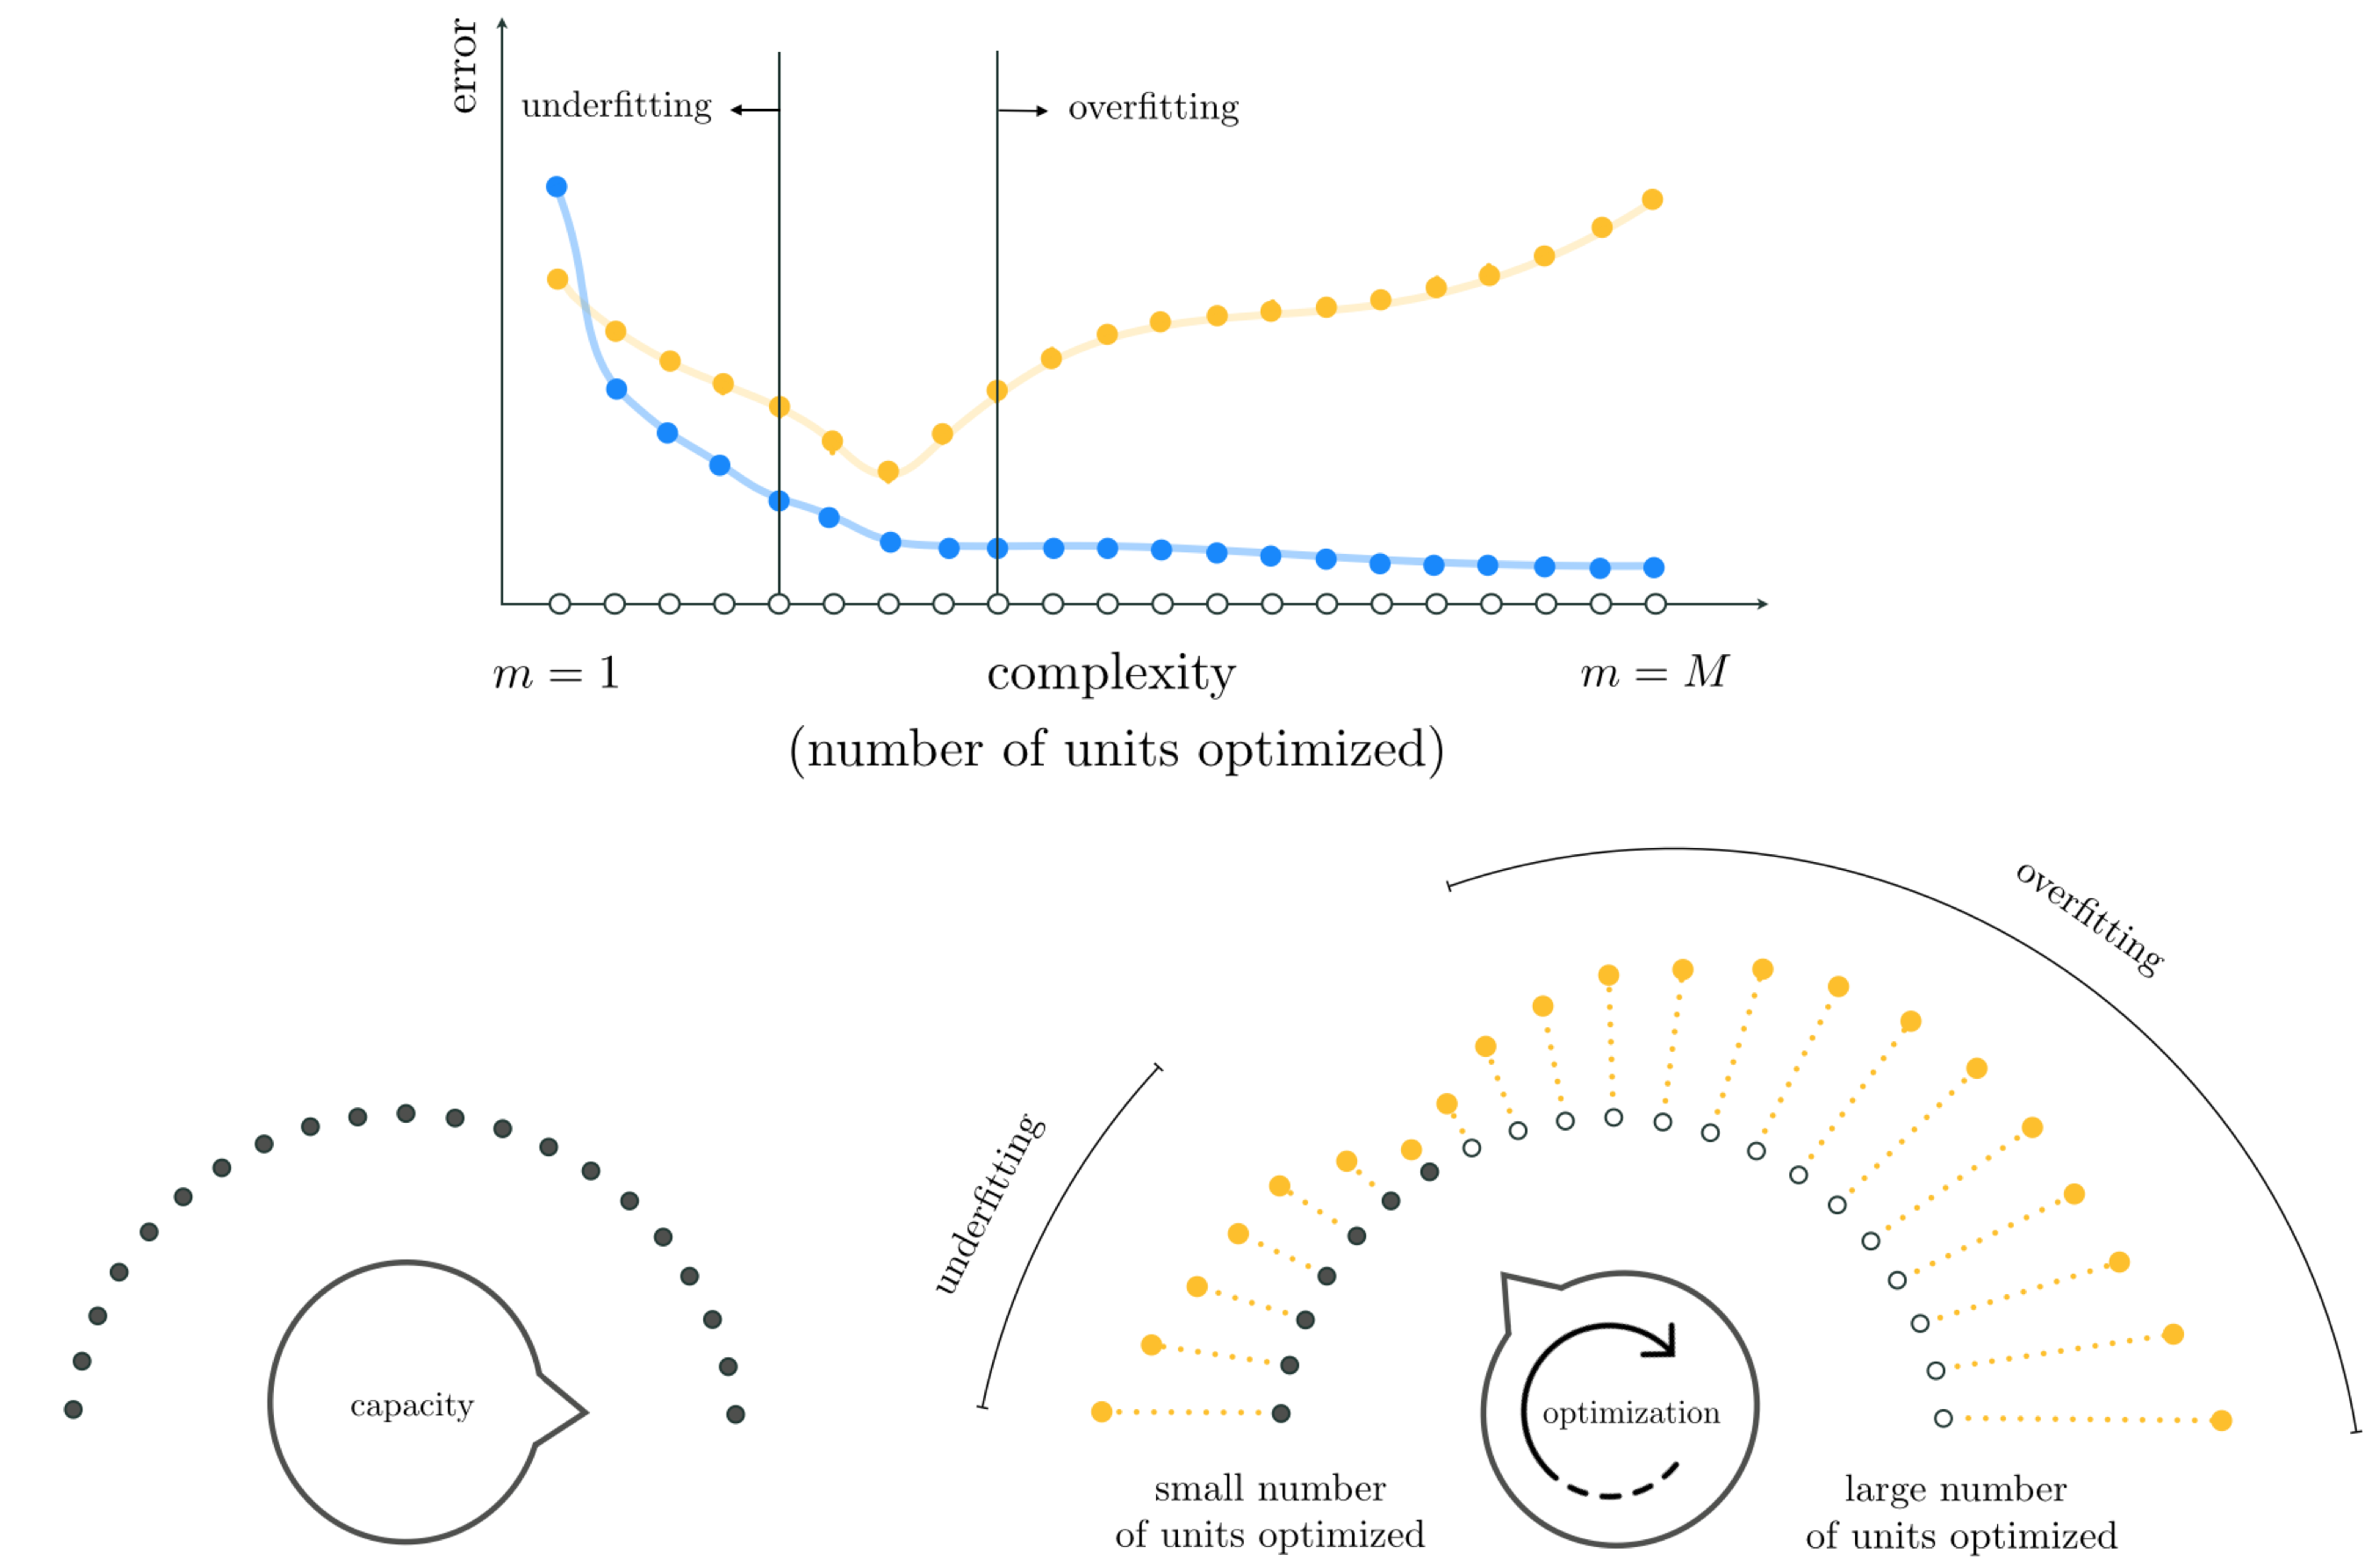

In [ ]:
Image(image_path_1)

<a id='figure-11-32'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.32 </strong> <em> 
(top panel) Prototypical training and validation error curves associated with a completed run of boosting. (bottom panels) With boosting we fix our capacity dial all the way to the right (at some high capacity value) and begin with our optimization dial set all the way to the left.  We then slowly turn our optimization dial from left to right, with each notch on the optimization dial denoting the complete optimization of one additional unit of the model, increasing the complexity of each subsequent model created with respect to the training set.  See text for further details.
</em>
</figcaption>
</figure>

---

Using the capacity/optimization dial conceptualization first introduced in Section 11.2.4, we can think about boosting as starting with our *capacity dial* set all the way to the *right* at some high value (e.g., some large value of $M$), and fidgeting with the *optimization dial* by turning it very slowly from left to right starting at the far left (as depicted in the bottom row of Figure 11.15).  As discussed in Section 11.3.2 and summarized visually in the bottom row of Figure 11.25, with real data this general configuration (setting the capacity dial to the right, and adjusting optimization dial) allows our *optimization dial* to (roughly speaking) govern the complexity of a tuned model based on how well we optimize (the more we optimize a high capacity model the higher its complexity with respect to the training data becomes).  In other words with this configuration our optimization dial (roughly speaking) becomes the sort of fine resolution *complexity* dial we aimed to construct at the outset of the Chapter (see Section 11.1).  With our optimization dial turned all the way to the left we begin our search with a low complexity tuned model (called $\text{model}_1$) consisting of a single unit of a universal approximator having its parameters fully optimized.  As we progress through rounds of boosting we turn the optimization dial gradually from left to right (here each notch on the optimization dial denotes the complete optimization of one additional unit) optimizing (to completion) a single weighted unit of our original high capacity model, so that at the $m^{th}$ round our tuned model (called $\text{model}_m$) consists of $m$ individually but fully tuned units.  

Our ultimate aim in doing this is of course to determine a setting of the optimization dial / determine an appropriate number of tuned units that minimizes validation error.  We visualize this concept in [Figure 11.33](#figure-11-33) by wrapping the prototypical validation error curve (shown in its top panel of this Figure) around the optimization dial (shown in its bottom right panel) from left to right, as well as the generic markings denoting underfitting and overfitting.  By using validation error we automate the process of setting our optimization dial to the proper setting - where validation error is minimal.

Whether we use fixed-shape, neural network, or tree-based units with boosting we will naturally prefer units with *low capacity* so that the resolution of our model search is as fine-grained as possible. When we start adding units one-at-a-time we turn our optimization dial clockwise from left to right.  We want this dial turning to be done as smoothly as possible so that we can determine the lowest validation error model as accurately as possible. This is depicted in the left panel of [Figure 11.33](#figure-11-33). If we used *high capacity* units at each round of boosting the resulting model search will be much coarser, as adding each additional unit results in aggressively turning the dial from left to right leaving large gaps in our model search, as depicted in the right panel of [Figure 11.33](#figure-11-33).   This kind of low resolution search could easily result in us skipping over the complexity of an optimal model.  The same can be said as to why we add only one unit at-a-time with boosting, tuning its parameters alone at each round. If we added more than one unit at-a-time, or if we re-tuned *every* parameter of *every* unit at each step of this process not only would we have significantly more computation to perform at each step but the performance difference between subsequent models could be quite large and we might easily miss out on an ideal model.

---

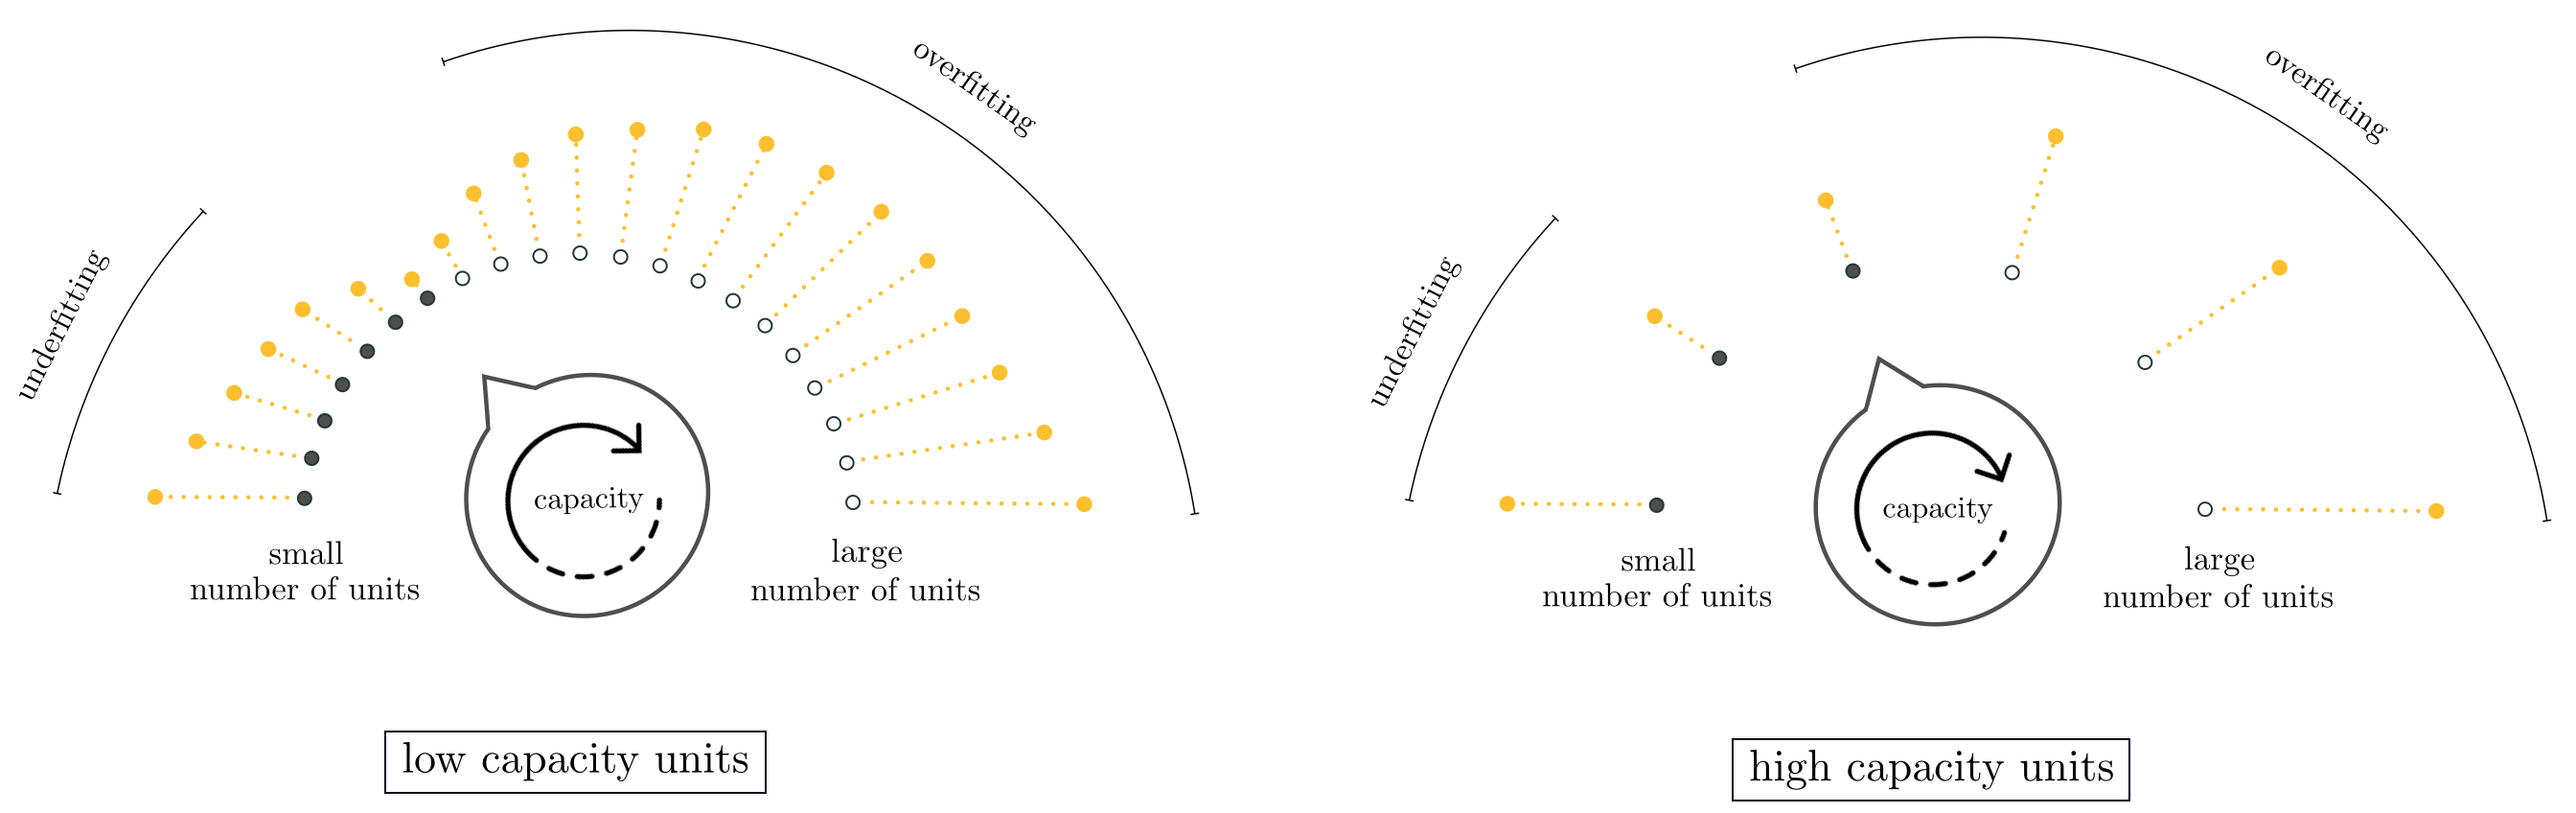

In [ ]:
Image(image_path_2)

<a id='figure-11-33'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.33 </strong> <em> 
(left panel) Using low capacity units makes the boosting procedure a high (or fine) resolution search for optimal model complexity. (right panel) Using high capacity units makes boosting a low (or coarse) resolution search for optimal model complexity. See text for further details.
</em>
</figcaption>
</figure>

---

##  Technical details

Formalizing our discussion of boosting above, we begin with a set of $M$ nonlinear features or units from a single family of universal approximators

\begin{equation}
\mathcal{F} = \{f_{1}\left(\mathbf{x}\right),\,f_{2}\left(\mathbf{x}\right),\,\ldots,\,f_M\left(\mathbf{x}\right)\}.
\end{equation}

We add these units sequentially or one-at-a-time building a set of $M$ tuned models $\left[\text{model}_m\right]_{m=1}^M$ that increase in complexity with respect to the training data, from $m=1$ to $m=M$, ending with a generic nonlinear model composed of $M$ units.  We will express this final boosting-made model slightly differently than above, in particular re-indexing the units it is built from as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_{s_1}\left(\mathbf{x}\right){w}_{1} +  f_{s_2}\left(\mathbf{x}\right){w}_{2} + \cdots + f_{s_M}\left(\mathbf{x}\right)w_{M}.
\label{equation:final-boosting-model}
\end{equation}

Here we have re-indexed the individual units to $f_{s_m}$ (and the corresponding weight $w_{m}$) to denote the unit from the entire collection in $\mathcal{F}$ added at the $m^{th}$ round of the boosting
process.  The linear combination weights $w_0$ through $w_M$ along with any additional
weights internal to $f_{s_1},\,f_{s_2},\,\ldots,\,f_{s_M}$ are
represented collectively in the weight set $\Theta$.

The process of boosting is performed in a total of $M$ rounds, one
for each of the units in Equation (2).  At each round we determine which unit, when added to the running model, best lowers its training error.  We then measure the corresponding validation error provided by this update, and in the end after all rounds of boosting are complete, use the lowest validation error measurement found to decide which round provided the best overall model.

For the sake of simplicity in describing the formal details of boosting, we will center our discussion on a single problem: nonlinear regression on the training dataset $\left\{\left(\mathbf{x}_p,\,y_p\right)\right\}_{p=1}^P$ employing the Least Squares cost. However, the principles of boosting we will see remain *exactly* the same for other learning tasks (e.g., two-class and multi-class classification) and their associated costs.

---

### Round $0$ of boosting

We begin the boosting procedure by tuning the bias 

\begin{equation}
\text{model}_0^{\,}\left(\mathbf{x},\Theta_0\right) = w_0^{\,}
\end{equation}

whose weight set $\Theta_0^{\,} = \left\{ w_0\right\}$ contains a
single bias weight, which we can easily tune by minimizing an
appropriate cost over this variable alone. With this in mind, to find the optimal value for $w_0$ we minimize the Least Squares cost

\begin{equation}
\frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_0^{\,}\left(\mathbf{x}_p,\Theta_0 \right)  - \overset{\,}{y}_{p}^{\,}\right)^{2} =  \frac{1}{P}\sum_{p=1}^{P}\left(w_0^{\,}   - \overset{\,}{y}_{p}^{\,}\right)^{2}
\end{equation}

giving the optimal value for $w_0$ which we denote as $w_0^{\star}$.
We fix the bias weight at this value forever more throughout the
process.

---

### Round $1$ of boosting

Having tuned the only parameter of $\text{model}_0$ we now
*boost* its complexity by adding the weighted unit
$f_{s_1}\left(\mathbf{x}\right)w_{1}$ to it, resulting in a modified
running model which we call $\text{model}_1$

\begin{equation}
\text{model}_1^{\,}\left(\mathbf{x},\Theta_1^{\,}\right) = \text{model}_0^{\,}\left(\mathbf{x},\Theta_0^{\,}\right) + f_{s_1}\left(\mathbf{x}\right)w_{1}^{\,}.
\end{equation}

Note here the parameter set $\Theta_1$ contains $w_{1}$ and any parameters internal to the unit $f_{s_1}$. To determine which unit in our set $\mathcal{F}$ best lowers the training error, we press
$\text{model}_1$ against the data by minimizing

\begin{equation}
 \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_0^{\,}\left(\mathbf{x}_p,\Theta_0^{\,}\right) + f_{s_1}\left(\mathbf{x}_p^{\,}\right)w_1   - {y}_{p}^{\,}\right)^{2} =  \frac{1}{P}\sum_{p=1}^{P}\left(w_0^{\star} + f_{s_1}\left(\mathbf{x}_p\right)w_1  - \overset{\,}{y}_{p}^{\,}\right)^{2}
\end{equation}

for every unit $f_{s_1} \in \mathcal{F}$.

Note that since the bias weight has already been set optimally in the
previous round we only need tune the weight $w_{1}$ as well as the
parameters internal to the nonlinear unit $f_{s_1}$. Also note, in particular, that with neural networks all nonlinear units take precisely the same form, and therefore we need not solve $M$ versions of the optimization problem above, one for every unit in $\mathcal{F}$, as we would do when using fixed-shape or tree-based units. Regardless of the type of universal approximator employed, round $1$ of boosting ends upon finding the optimal $f_{s_1}$ and $w_1$, which we denote respectively as $f^{\star}_{s_1}$ and $w^{\star}_1$, and keep fixed moving forward.

---

### Round $m>1$ of boosting

In general, at the $m^{th}$ round of boosting we begin with $\text{model}_{m-1}$ consisting of a bias term and $m-1$ units of the form
    
\begin{equation}
\text{model}_{m-1}\left(\mathbf{x},\Theta_{m-1}\right) = w_0^{\star} + f_{s_1}^{\star}\left(\mathbf{x}\right){w}_{1}^{\star} +  f_{s_2}^{\star}\left(\mathbf{x}\right){w}_{2}^{\star} + \cdots + f_{s_{m-1}}^{\star}\left(\mathbf{x}\right)w_{m-1}^{\star}.
\label{equation:cv_boosting_model_m_minus_1}
\end{equation}
    
Note that the parameters of this model have been tuned sequentially, starting with the bias $w_0^{\star}$ in round $0$, $w_1^{\star}$ and any internal parameters of $f_{s_1}^{\star}$ in round $1$, and so forth, up to $w_{m-1}^{\star}$ and any parameters internal to $f_{s_{m-1}}^{\star}$ in round $m-1$.
    
The $m^{th}$ round of boosting then follows the same pattern
outlined in round 1, where we seek out the best weighted unit 
$f_{s_m}\left(\mathbf{x}\right)w_{m}$ to add to our running model to best lower its training error on the dataset. Specifically, our $m^{th}$ model takes the form

\begin{equation}
\text{model}_m^{\,}\left(\mathbf{x},\Theta_m^{\,}\right) = \text{model}_{m-1}^{\,}\left(\mathbf{x},\Theta_{m-1}^{\,}\right) + f_{s_m}\left(\mathbf{x}\right)w_{m}
\label{equation:boosting-round-m-model-version-1}
\end{equation}

and we determine the proper unit (the identity of the index $s_m$) by minimizing

\begin{equation}
\begin{array}
\
 \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_{m-1}^{\,}\left(\mathbf{x}_p,\Theta_{m-1}^{\,}\right) + f_{s_m}\left(\mathbf{x}_p^{\,}\right)w_m   - {y}_{p}^{\,}\right)^{2} = \\ \frac{1}{P}\sum_{p=1}^{P}\left(w_0^{\star} + w_1^{\star}f^{\star}_{s_{1}}  + \cdots + f^{\star}_{s_{m-1}}\left(\mathbf{x}_p\right)w_{m-1}^{\star} + f_{s_m}\left(\mathbf{x}_p\right)w_m  - \overset{\,}{y}_{p}^{\,}\right)^{2}
 \end{array}
\end{equation}

over $w_m$, $f_{s_m}$ and its internal parameters (if they exist), which are contained in the parameter set $\Theta_m$.

Once again with fixed-shape or tree-based approximators, this entails solving $M$ (or $M-m+1$, if we decide to check only those units not used in previous rounds) such optimization problems and choosing the one with smallest training error. With neural networks, since each unit takes the same form, we need only solve one such optimization problem.

##  Early stopping

Once all rounds of boosting are complete note how we have generated a
sequence of \(M\) tuned models - denoted $\left[\text{model}_m\left(\mathbf{x},\Theta_m^{\,}\right)\right]_{m=1}^M$ - 
which gradually increases in nonlinear complexity from $m = 1$ to
$m = M$, and thus gradually decrease in training error. This gives us fine-grained control in selecting an appropriate model, as the jump in performance in terms of both the training and validation
errors between subsequent models in this sequence can be quite smooth in the sequence, provided we use low capacity units (as discussed in Section 11.5.1).

Once boosting is complete we select from our set of models the one that provides the lowest validation error. Alternatively, instead of running all $M+1$ rounds of boosting and deciding on an optimal model after the fact, we can attempt to *halt* the procedure when the validation error first starts to increase. This concept, referred to as *early stopping*, leads to a more computationally efficient implementation of boosting, but one needs to be careful in deciding when the validation error has really reached its minimum as it can oscillate up and down multiple times (as mentioned in Section 11.3), and need not take the simple generic form illustrated in the top panel of [Figure 11.32](#figure-11-32).  There is no ultimate solution to this issue - thus ad hoc solutions are typically used in practice when early stopping is employed. 

## An inexpensive but effective enhancement

A slight adjustment at each round of boosting, in the form of addition of an individual bias, can significantly improve the algorithm.  Formally at the $m^{th}$ round of boosting instead of forming $\text{model}_m$ as shown in Equation (9), we add an additional bias weight $w_{0, m}$ as

\begin{equation}
\text{model}_m^{\,}\left(\mathbf{x},\Theta_m^{\,}\right) = \text{model}_{m-1}^{\,}\left(\mathbf{x},\Theta_{m-1}^{\,}\right) + w_{0, m} + f_{s_m}\left(\mathbf{x}\right)w_{m}.
\label{equation:boosting-round-m-model-version-2}
\end{equation}

This simple adjustment results in greater flexibility and generally better overall performance by allowing units to be adjusted 'vertically' at each round (in the case of regression) at the minimal cost of adding a single variable to each optimization sub-problem.  Note that once tuning is done, the optimal bias weight $w^{\star}_{0, m}$ can be absorbed into the bias weights from previous
rounds, creating a single bias weight $w^{\star}_{0}+w^{\star}_{0, 1}+\cdots +w^{\star}_{0, m}$ for the entire model.

This enhancement is particularly useful when using fixed-shape or neural network units for boosting, as it is redundant
when using tree-based approximators because they already have individual bias terms baked into them that always allow for this kind of vertical adjustment at each round of boosting (in the jargon of machine learning boosting with tree-based learners is often referred to as *gradient boosing* - see Section 14.5.  To see this note that while the most common way of expressing a stump taking in $N=1$ dimensional input is 

\begin{equation}
f\left(x\right)=\begin{cases}
\begin{array}{c}
v_{1}\\
v_{2}
\end{array} & \begin{array}{c}
x<s \\
x>s
\end{array}\end{cases}
\end{equation}

it is also possible to express $f(x)$ equivalently as

\begin{equation}
f(x) = b + w\,h(x)
\label{equation:stump-chapter-14-bias-feature-weight-version}
\end{equation}

where $b$ denotes an individual bias parameter for the stump and $w$ is an associated weight that scales $h(x)$, which is a simple step function with fixed levels and a split at $x=s$

\begin{equation}
h\left(x\right)=\begin{cases}
\begin{array}{c}
0 \\
1
\end{array} & \begin{array}{c}
x<s\\
x>s
\end{array}\end{cases}
\end{equation}

Expressing the stump in this equivalent manner allows us to see that every stump unit does indeed have its own individual bias parameter, making it redundant to add an individual bias at each round when boosting with stumps (and the same holds for stumps taking in general $N$ dimensional input as well).

---

#### <span style="color:#a50e3e;">Example 11.11:</span>  Boosting regression using stump units

In this example we use a sinusoidal regression dataset consisting of $P=21$ datapoints, and construct a set of $B = 20$ stump
features for this dataset (see Section 11.2.3). In the animation below we illustrate the result of $M = 100$ rounds of boosting (meaning many of the stumps are used multiple times). We split the dataset into $\frac{2}{3}$ training and $\frac{1}{3}$ validation, which are color-coded in light blue and yellow, respectively. Depicted in the Figure are resulting regression fits and associated training/validation errors for several rounds of boosting.  This example is discussed further in Section 14.5.

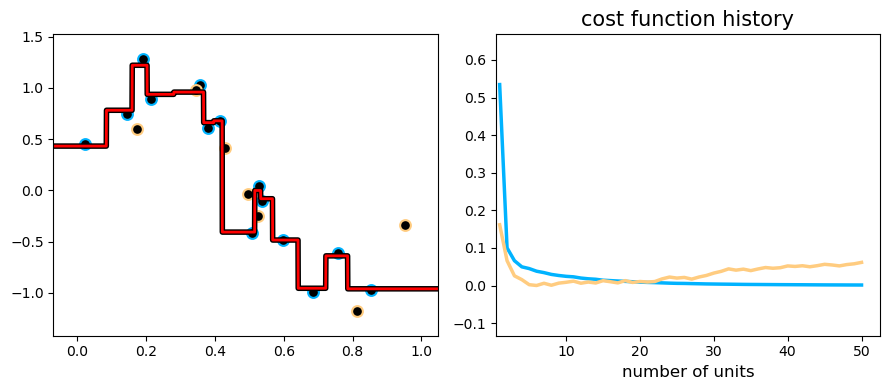

In [ ]:
# import data
data = np.loadtxt(data_path_1,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# import booster
mylib = stump_booster.Setup(x,y)

# choose normalizer
mylib.choose_normalizer(name = 'standard')

# pick training set
mylib.make_train_valid_split(train_portion=0.66)

# choose cost|
mylib.choose_cost(name = 'least_squares')

# choose optimizer
mylib.choose_optimizer('newtons_method',max_its=1)

# run boosting
mylib.boost(51)

# produce animation
frames = 50
anim = boosting_regression_animators.Visualizer(data_path_1)
anim.animate_trainval_boosting(video_path_1,mylib,frames,fps=5)

In [ ]:
show_video(video_path_1)

##  Similarity to feature selection

The careful reader will notice how similar the boosting procedure is to the one introduced in [Section 9.6](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_6_Boosting.html) in the context of feature selection. Indeed principally the two approaches are entirely similar, except with boosting we do not select from a set of given input features but create them ourselves based on a chosen universal approximator family. Additionally, unlike feature selection where our main concern is *human interpret-ability*, we primarily use boosting as a tool for cross-validation. This means that unless we specifically prohibit it from occurring, we can indeed select the same feature multiple times in the boosting process as long as it contributes positively towards finding a model with minimal validation error.

These two use-cases for boosting, i.e., feature selection and
cross-validation, can occur together, albeit typically in the context
of linear modeling as detailed in [Section 9.6](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_6_Boosting.html). Often in such instances
cross-validation is used with a linear model as a way of automatically
selecting an appropriate number of features, with human interpretation of the resulting selected features still in mind. On the other hand, rarely is feature selection done when employing a nonlinear model based on features from a universal approximator due to the great difficulty in the human interpret-ability of nonlinear features. The rare exception to this rule is when using tree-based units which, due to their simple structure, can in particular instances be readily interpreted by humans.

##  The residual perspective with regression

Here we describe a common interpretation of boosting in the context of
regression, that of sequentially fitting to the *residual* of a regression dataset. To see what this means, consider the following Least Squares cost function where we have inserted a boosted
model at the $m^{th}$ round of its development

\begin{equation}
g\left(\Theta_m^{\,}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_m^{\,}\left(\mathbf{x}_p,\Theta_m^{\,}\right) - y_p\right)^2.
\label{equation:boosting-LS-cost}
\end{equation}

We can write our boosted model recursively as

\begin{equation}
\text{model}_m^{\,}\left(\mathbf{x}_p^{\,},\Theta_m^{\,}\right) = \text{model}_{m-1}^{\,}\left(\mathbf{x}_p^{\,},\Theta_{m-1}^{\,}\right) + f_m^{\,}\left(\mathbf{x}_p\right)w_m^{\,}
\label{equation:boosting-LS-recursive-model}
\end{equation}

where all of the parameters of the $\left(m-1\right)^{th}$ model (i.e., $\text{model}_{m-1}$) are already tuned. Combining Equations (15) and (16) we can re-write the Least Squares cost as

\begin{equation}
g\left(\Theta_m^{\,}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(f_m^{\,}\left(\mathbf{x}_p^{\,}\right)w_m^{\,} - \left(y_p^{\,} - \text{model}_{m-1}^{\,}\left(\mathbf{x}_p^{\,}\right)\right)\right)^2.
\end{equation}

By minimizing this cost we look to tune the parameters of a
single additional unit so that

\begin{equation}
f_m^{\,}\left(\mathbf{x}_p\right)w_m^{\,}\approx y_p^{\,} - \text{model}_{m-1}^{\,}\left(\mathbf{x}_p^{\,}\right)
\end{equation}

for all $p$, or in other words, so that this fully tuned unit approximates our original output $y_p$ minus the contribution of the previous model. This quantity, the difference between our original output and the contribution of the $\left(m-1\right)^{th}$ model, is often called the *residual*: it is what is left to represent after subtracting off what was learned by the $\left(m-1\right)^{th}$ model.

---

#### <span style="color:#a50e3e;">Example 11.13:</span>  Boosting regression and the 'fitting to the residual' perspective'

In the animation below we illustrate the process of boosting $M = 5000$ single-layer $\texttt{tanh}$ units to a toy regression dataset. In the top panels we show the dataset along with the fit provided by $\text{model}_m$ at the $m^{th}$ step of boosting for select values of $m$. In the corresponding bottom panels we plot the *residual* at the same step, as well as the fit provided by the corresponding $m^{th}$ unit $f_m$. As boosting progresses, the fit on the original data improves while (simultaneously) the residual shrinks.

In [ ]:
# load in dataset
data = np.loadtxt(data_path_1,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:] )

# boosting procedure
num_units = 15
runs2 = []
for j in range(num_units):    
    # import the v1 library
    mylib2 = net_booster.Setup(x,y)
    
    # choose normalizer
    mylib2.choose_normalizer(name = 'standard')

    # choose normalizer
    mylib2.make_train_valid_split(train_portion = 1)

    # choose cost
    mylib2.choose_cost(name = 'least_squares')

    # choose optimizer
    mylib2.choose_optimizer('gradient_descent',max_its=10000,alpha_choice = 10**(-1))
    
    # choose activation 
    mylib2.choose_activation(activation = 'relu')
    
    # run boosting
    mylib2.boost(1,verbose=False)
    mylib2.model = mylib2.models[-1]

    # add model to list
    runs2.append(copy.deepcopy(mylib2))
    
    # cut off output given model
    normalizer = mylib2.normalizer
    ind = np.argmin(mylib2.train_cost_vals[0])
    y_pred =  mylib2.models[-1](mylib2.normalizer(x))
    y -= y_pred

# animate the business
frames = num_units
demo2 = boosting_regression_animators.VisualizerV3(data_path_1)
demo2.animate_boosting(video_path_2,runs2,frames,fps=2)

In [ ]:
show_video(video_path_2)

---